# Gamma spec analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gs_analysis as ga

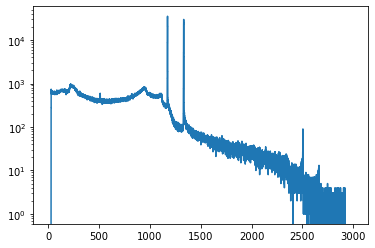

In [2]:
path = "test_data/Co_60_raised_1.spe"
counts, ebins = ga.get_spect(path)

ga.plot_spec(counts, erg=ebins)

## Peak finder
### SciPy.signal version

(ebins is x, count is the data in the file and y)
* smoothing func in ga removes noise

#### Peak detection process
(https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2631518/)
- raw spec -> smooth spec -> baseline correction -> peaks
okay so can get raw, smoothed and peaks, baseline?

- look at scipy.signal savgol_filter too - looks where 2nd deriv is large, then finds width and then midpooint (https://stackoverflow.com/questions/47519626/using-numpy-scipy-to-identify-slope-changes-in-digital-signals)

In [3]:
from scipy.signal import find_peaks, peak_prominences, savgol_filter, peak_widths, argrelmin

[1398 3210 3646]


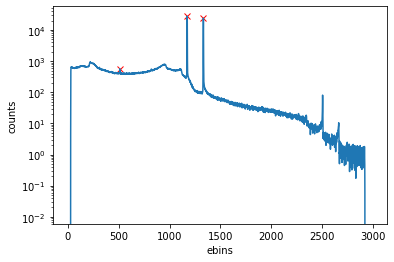

In [4]:
def sp_peak_finder(x, prominence, wlen):

    sf = ga.five_point_smooth(x)
    smooth = np.array(sf)
    sf2 = ga.five_point_smooth(smooth)
    smooth2 = np.array(sf2)
    peaks,_ = find_peaks(sf2, prominence = prominence, wlen = wlen)
    
    return(smooth2, peaks)

def peak_identifier(smooth_counts, ebins, peaks):
    plt.plot(ebins[peaks], smooth_counts[peaks], "xr"); plt.plot(ebins, smooth_counts)
    plt.xlabel('ebins')
    plt.ylabel('counts')
    plt.yscale('log') 
    plt.show
    
smoothed_counts_sp, peaks_sp = sp_peak_finder(counts, 90, 10)
print(peaks_sp)

plot_sp = peak_identifier(smoothed_counts_sp, ebins, peaks_sp)

In [5]:
proms = peak_prominences(counts, peaks_sp)[0]
print(proms)

#why is the first one zero? surely if it was 0 it wouldnt show up when i put the prominence to be at least 90??

[    0. 35274. 29723.]


<ipython-input-5-59a6846d2c72>:1: PeakPropertyWarning: some peaks have a prominence of 0
  proms = peak_prominences(counts, peaks_sp)[0]


## Diff version
smooth, find maxima with scipy or 2nd deriv, then ?
(https://arxiv.org/pdf/hep-ex/9506013.pdf)

[3210 3645]


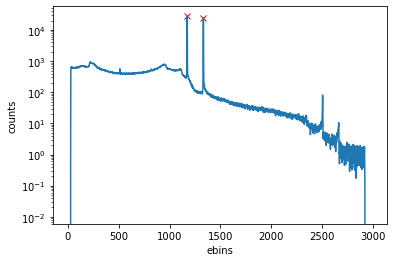

In [6]:
#fits a polynomial to the curve in the specified window
#then for the peaks - uses 2nd derivative, looks for places where 2nd deriv is at least half its max size
#then finds start and end points then mid points
#do the same method with the smoother from steve instead 

def peak_finder_savgol(x, wlen):
    smooth_sig = ga.five_point_smooth(x)
    smooth_signal = np.array(smooth_sig)
    smooth_sig2 = ga.five_point_smooth(smooth_signal)
    smooth_signal2 = np.array(smooth_sig2)
    d2x = savgol_filter(smooth_signal2, window_length=wlen, polyorder=2, deriv=2)
    max_d2x = np.max(np.abs(d2x))
    large = np.where(np.abs(d2x) > max_d2x/2)[0]
    peak_width = np.diff(large) > wlen
    peak_start= np.insert(large[1:][peak_width], 0, large[0])
    peak_end = np.append(large[:-1][peak_width], large[-1])
    mid_point = ((peak_start + peak_end) / 2).astype(np.int)

    return(smooth_signal2, mid_point, peak_start, peak_end, peak_width) 

smooth_counts_savgol, peaks_savgol, peak_start, peak_end, peak_width = peak_finder_savgol(counts, 11)
print(peaks_savgol)

plot_savgol = peak_identifier(smooth_counts_savgol, ebins, peaks_savgol)

#this one also uses the smoothing function on top of the savgol - takes out even more noise
#window length for savgol needs to be odd

## Get Peak Counts Stuff
So here i need to get the peak counts 
* look at the funcs steve has written
* peak fitting, get_counts, gaussian, background subtraction etc
* func ive wrote doesnt work for peaks that overlap so look into that once done basic get counts stuff

Also whats the difference between the ga.gaussian function and the ga.fit_peak? both are gaussian yes? so why doesnt fit_peak use the ga.gaussian?

- Note:
    * Gross counts is total
    * Net is minus the background - useful one i believe

#### Basic method idea (stick into a func later)
- Get the 'channels' - i think this is peak start and peak end in the savgol func but not in the first one so need to add in later
- Get the net counts - using the positions from above

then for plotting (idk what this is actually useful for? i dont think this is necessary for counts but play about anyway) - ohhh i think you can find start and end points by fitting the peak to a gaussian so use this for func1 and compare to savgol start and ends:
- get_peak_roi - need peak pos(index?), ebins, counts
- fit_peak
- somehow get start and end from that then get counts

### Savgol

In [27]:
#counts for the savgol func as peak start and end is found so doesnt need gaussian or whatever
smooth_counts_savgol, peaks_savgol, peak_start, peak_end, peak_width = peak_finder_savgol(counts, 11)

print('peaks', peaks_savgol)

s = peak_start
e = peak_end
print('peak start', s)
print('peak end', e)

#net__counts for savgol peak 1 (iterate later)
savgol_counts = ga.net_counts(smooth_counts_savgol, s[0], e[0], m=1)
print('savgol peak at 3210, net counts = ', savgol_counts)

peaks [3210 3645]
peak start [3208 3644]
peak end [3212 3647]
savgol peak at 3210, net counts =  50461.09465020575


### Scipy peak finder counts

In [26]:
#function to return counts (no need to plot)
#maybe get it to return ebin value instead of peak index?
#the description of this is bad but i dont know how to say it better
def peak_counts(peaks, index, smooth_counts, ebins):
    """ Index is the peak array index for the peak that counts is required for
        i.e [0], NOT the peak index itself i.e [3210]
        Returns the index of the peak and its calculated count
    """    
    x, y = ga.get_peak_roi(peaks[index], smooth_counts, ebins, offset=10)
    
    length = len(x)
    start_pos = x[0]
    end_pos = x[length - 1]
    start, = np.where(ebins == start_pos)
    end, = np.where(ebins == end_pos)
    
    counts = ga.net_counts(smooth_counts, start[0], end[0], m=1)
    
    return(peaks[index], counts)

sp_peak_index, sp_counts = peak_counts(peaks_sp, 1, smoothed_counts_sp, ebins)
print('peak at', sp_peak_index, ', net counts =', sp_counts)

peak at 3210 , net counts = 190260.4732510288


[1398 3210 3646]
peak index 3210
peak max point count 27674.135802469133
start index [3200]
end index [3219]
start count 510.6419753086419
end count 496.58024691358014
net counts scipy 190260.4732510288


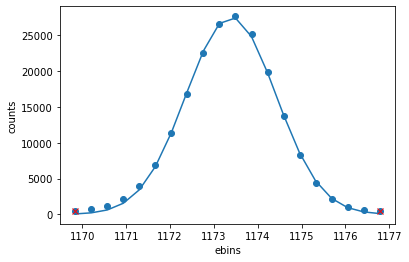

'\nokay the values are different for savgol and this one,\nsavgol peak start 3208, this one is 3200\nsavgol peak end 3212, this one is 3219\nwhy such a big difference on the counts then? \n\n'

In [10]:
#for the first function 2nd peak (first on the savgol one above)
#also note - idk why but the gaussian doesnt fit the 511 peak
print(peaks_sp)

x, y = ga.get_peak_roi(peaks_sp[1], smoothed_counts_sp, ebins, offset=10) 

params = ga.fit_peak(x, y)
#print(params) #[0] is a [1] is x0 [2] is sigma for ga.gaussian(i think)

length = len(x)
start_pos = x[0]
end_pos = x[length - 1]
start, = np.where(ebins == start_pos)
end, = np.where(ebins == end_pos)
print('start index',start)
print('end index', end)

sy = np.interp(start_pos, ebins, smoothed_counts_sp)
print('start count',sy)
ey = np.interp(end_pos, ebins, smoothed_counts_sp)
print('end count',ey)


counts_sp = ga.net_counts(smoothed_counts_sp, start[0], end[0], m=1)
print('net counts scipy',counts_sp)

plt.figure(figsize=(6, 4))
plt.scatter(x, y)
plt.ylabel('counts')
plt.xlabel('ebins')
plt.plot(x, ga.gaussian(x, params[0], params[1], params[2]))
plt.plot(start_pos, sy, 'xr')
plt.plot(end_pos, ey, 'xr')
plt.plot()
plt.show()

1172.76086 22538.592592592588
1169.837076 1321.508371
1172.76086 22538.592592592588


<function matplotlib.pyplot.show(*args, **kw)>

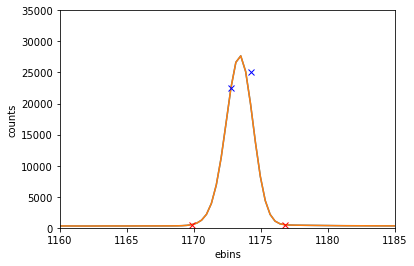

In [81]:
#scipy
a = ebins[3200]
b = ebins[3219]
sy = np.interp(start_pos, ebins, smoothed_counts_sp)
ey = np.interp(end_pos, ebins, smoothed_counts_sp)

#savgol
sav_c = smooth_counts_savgol[3208: 3212]
s = peak_start
e = peak_end
s_s = sav_c[0]
s_e = sav_c[len(sav_c)-1]
sx = ebins[s[0]]
ex = ebins[e[0]]
print(sx, s_s)

#plotting to see start and end pos differences 
plt.plot(ebins, smoothed_counts_sp)
plt.plot(ebins, smooth_counts_savgol)
plt.xlabel('ebins')
plt.ylabel('counts')
plt.xlim([1160, 1185])
plt.ylim([0, 35000]) 
plt.plot(sx, s_s, 'xb')#savgol
plt.plot(ex, s_e, 'xb')
plt.plot(a, sy, 'xr')#scipy
plt.plot(b, ey, 'xr')
plt.show

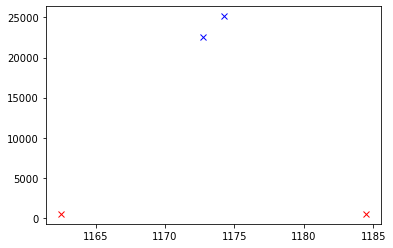

In [71]:
plt.plot(a, sy, 'xr')
plt.plot(b, ey, 'xr')

plt.plot(sx, s_s, 'xb')
plt.plot(ex, s_e, 'xb')

## Comparison for count issue

In [11]:
#comparison stuff to see where the count issue is 
savgol_counts = ga.net_counts(smooth_counts_savgol, s[0], e[0], m=1)
print('savgol peak at 3210, net counts = ', savgol_counts)
print('3210 peak start savgol', s[0])
print('3210 peak end savgol', e[0])
savgol_bg = ga.calc_bg(smooth_counts_savgol, s[0], e[0], m=1)
print('savgol bg = ', savgol_bg)
sav_gc = ga.gross_count(smooth_counts_savgol, s[0], e[0])
print('savgol gc = ', sav_gc)
print('savgol peak counts', smooth_counts_savgol[3208: 3212])

low_sum_sav = sum(smooth_counts_savgol[s[0] - 2:s[0]])
print('low sum range sav', smooth_counts_savgol[s[0] - 2:s[0]])
print('sav low sum', low_sum_sav)
high_sum_sav = sum(smooth_counts_savgol[e[0]:e[0] + 2])
print('sav high sum', high_sum_sav)
savbg = (low_sum_sav + high_sum_sav) * ((e[0] - s[0] + 1) / 6)
print('savbg', savbg)


counts_sp = ga.net_counts(smoothed_counts_sp, start[0], end[0], m=1)
print('scipy peak at 3210 net counts = ', counts_sp)
print('3210 peak start scipy',start)
print('3210 peak end scipy', end)
sp_bg = ga.calc_bg(smoothed_counts_sp, start[0], end[0], m=1)
print('scipy bg = ', sp_bg)
sp_gc = ga.gross_count(smoothed_counts_sp, start[0], end[0])
print('scipy gc = ', sp_gc)
print('scipy peak counts', smoothed_counts_sp[3200: 3219])

low_sum_sp = sum(smoothed_counts_sp[start[0] - 2:start[0]])
print('low sum range sp', smoothed_counts_sp[start[0] - 2:start[0]])
print('sp low sum', low_sum_sp)
high_sum_sp = sum(smoothed_counts_sp[end[0]:end[0] + 2])
print('sp high sum', high_sum_sp)
spbg = (low_sum_sp + high_sum_sp) * ((end[0] - start[0] + 1) / 6)
print('spbg', spbg)



'''
okay so its obvious that scipy has more channels
savgol takes the peak start and end pos later, not a huge deal and shouldnt account for such a big diff - though the
gross counts for savgol is 90k less than scipy
but - why is scipy background so low? 
this is clearly the main issue but im not sure how to 'fix' it, or what would even count as fixing it
'''



savgol peak at 3210, net counts =  50461.09465020575
3210 peak start savgol 3208
3210 peak end savgol 3212
savgol bg =  51538.8683127572
savgol gc =  101999.96296296295
savgol peak counts [22538.59259259 26636.85185185 27674.13580247 25150.38271605]
low sum range sav [11303.01234568 16874.62962963]
sav low sum 28177.641975308637
sav high sum 33669.0
savbg 51538.8683127572
scipy peak at 3210 net counts =  190260.4732510288
3210 peak start scipy [3200]
3210 peak end scipy [3219]
scipy bg =  5598.600823045267
scipy gc =  195859.07407407407
scipy peak counts [  510.64197531   749.03703704  1230.56790123  2174.32098765
  3925.82716049  6887.85185185 11303.01234568 16874.62962963
 22538.59259259 26636.85185185 27674.13580247 25150.38271605
 19928.50617284 13740.49382716  8262.7654321   4391.12345679
  2152.56790123  1079.79012346   647.97530864]
low sum range sp [341.85185185 395.09876543]
sp low sum 736.9506172839506
sp high sum 942.6296296296296
spbg 5598.600823045267


"\nokay so its obvious that scipy has more channels\nsavgol takes the peak start and end pos later, not a huge deal and shouldnt account for such a big diff - though the\ngross counts for savgol is 90k less than scipy\nbut - why is scipy background so low? \nthis is clearly the main issue but im not sure how to 'fix' it, or what would even count as fixing it\n"

## Playing about with second derivative stuff

[  1123.82997748   1734.38724155   3375.66369273   5997.44980498
   9129.27134422  11242.99207015   9170.12823452   1157.85988345
 -11827.05227754 -23579.3409697  -27639.25624451 -20785.68418579
  -7177.79549927   5896.39377791  12619.07630629  12539.94727426
   8730.18187247   4674.27297604   1971.10563538    807.63387057]
[ 1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.
  1.  1.]
Roots = [1173.41521767]


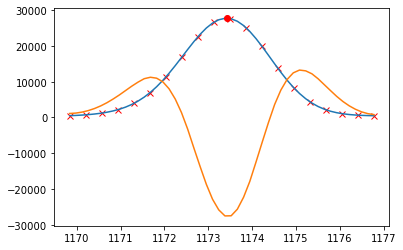

In [12]:
from scipy.interpolate import UnivariateSpline

x, y = ga.get_peak_roi(peaks_sp[1], smoothed_counts_sp, ebins, offset=10)

y_spl = UnivariateSpline(x,y,s=0,k=4)
plt.plot(x,y,'xr')
x_range = np.linspace(x[0],x[-1])
plt.plot(x_range,y_spl(x_range))

y_spl_2d = y_spl.derivative(n=2)
plt.plot(x_range,y_spl_2d(x_range))
d2 = y_spl_2d(x)
print(d2)
sign_change = np.sign(d2)
print(sign_change)
print('Roots = {}'.format(y_spl.derivative().roots()))
minmax = y_spl.derivative().roots()
plt.plot(minmax, y_spl(minmax), 'ro ')

#only one max since its a quadratic - cant get start andend from minima bc it doesnt have any
#the sign change of the second derivative is wrong i think
#i think ive just confused myself more here

#second deriv could be useful for hidden peaks though as it can amplify it

In [13]:
#my thinking here was to do a spline for the whole spectra and find the min points on there that could be used as the
#start and end positions but none of this works and to be honest i dont fully understand it enough to make it work
#i dont think itd be efficient anyway since it would give every minima
'''
s = interp1d(ebins, smoothed_counts_sp)
x_range = np.linspace(ebins[0],ebins[-1])
yr = s(x_range)
plt.plot(ebins, smoothed_counts_sp, 'r')
plt.plot(x_range, yr, 'b' )
plt.yscale('log')



ebinsa = ebins.astype(int)
print(ebinsa)
sca = smoothed_counts_sp.astype(int)

#plot_sp = peak_identifier(smoothed_counts_sp, ebins, peaks_sp)
print(len(smoothed_counts_sp[ebinsa]))
print(len(ebinsa))


tck,u = interpolate.splprep([ebins, smoothed_counts_sp],k=4,s=0)
out = interpolate.splev(u,tck)
print(out)

x_range = np.linspace(x[0],x[-1])
plt.plot(ebins, smoothed_counts_sp, 'ro')
plt.plot(out[0][ebinsa], out[1][sca], 'b' )
plt.yscale('log')


y_spl = UnivariateSpline(ebinsa, smoothed_counts_sp[ebinsa],s=0,k=4)
plt.plot(ebinsa, smoothed_counts_sp[ebinsa],'xr')
x_range = np.linspace(smoothed_counts_sp[0],smoothed_counts_sp[-1])
plt.plot(x_range,y_spl(x_range))
plt.yscale('log')


y_spl_2d = y_spl.derivative(n=2)
plt.plot(x_range,y_spl_2d(x_range))
d2 = y_spl_2d(smoothed_counts_sp[peaks_sp])
#sign_change = np.sign(d2)
#print(sign_change)
print('Roots = {}'.format(y_spl.derivative().roots()))
minmax = y_spl.derivative().roots()
print(minmax)
plt.plot(minmax, y_spl(minmax), 'ro ')
'''

"\ns = interp1d(ebins, smoothed_counts_sp)\nx_range = np.linspace(ebins[0],ebins[-1])\nyr = s(x_range)\nplt.plot(ebins, smoothed_counts_sp, 'r')\nplt.plot(x_range, yr, 'b' )\nplt.yscale('log')\n\n\n\nebinsa = ebins.astype(int)\nprint(ebinsa)\nsca = smoothed_counts_sp.astype(int)\n\n#plot_sp = peak_identifier(smoothed_counts_sp, ebins, peaks_sp)\nprint(len(smoothed_counts_sp[ebinsa]))\nprint(len(ebinsa))\n\n\ntck,u = interpolate.splprep([ebins, smoothed_counts_sp],k=4,s=0)\nout = interpolate.splev(u,tck)\nprint(out)\n\nx_range = np.linspace(x[0],x[-1])\nplt.plot(ebins, smoothed_counts_sp, 'ro')\nplt.plot(out[0][ebinsa], out[1][sca], 'b' )\nplt.yscale('log')\n\n\ny_spl = UnivariateSpline(ebinsa, smoothed_counts_sp[ebinsa],s=0,k=4)\nplt.plot(ebinsa, smoothed_counts_sp[ebinsa],'xr')\nx_range = np.linspace(smoothed_counts_sp[0],smoothed_counts_sp[-1])\nplt.plot(x_range,y_spl(x_range))\nplt.yscale('log')\n\n\ny_spl_2d = y_spl.derivative(n=2)\nplt.plot(x_range,y_spl_2d(x_range))\nd2 = y_spl_2